# Predicting Crime in US Communites
## Team member: Bibata Rabba Idi, Fatima Javid, JianHui (Jake) Li 

In [136]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

%matplotlib inline

In [137]:
# Load data
df = pd.read_csv('crimedata.csv')
df.head()

,communityName,state,countyCode,communityCode,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,11980,3.10,1.37,91.78,6.50,1.88,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,23123,2.82,0.80,95.57,3.44,0.85,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,29344,2.43,0.74,94.33,3.43,2.35,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,16656,2.40,1.70,97.35,0.50,0.70,...,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,Bemidjicity,MN,7.0,5068.0,11245,2.76,0.53,89.16,1.17,0.52,...,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79


In [138]:
# Shape of dataframe
df.shape

(2215, 146)

In [139]:
# Number of nulls from each column
df.isnull().sum()

communityName             0
state                     0
countyCode             1221
communityCode          1224
population                0
                       ... 
autoTheftPerPop           3
arsons                   91
arsonsPerPop             91
ViolentCrimesPerPop     221
nonViolPerPop            97
Length: 146, dtype: int64

In [140]:
# Total number of nulls
df.isnull().sum().sum()

44592

In [141]:
# Make a list of columns that contain nulls
cols_with_nulls = df.columns[df.isna().any()].tolist()
print(cols_with_nulls)

['countyCode', 'communityCode', 'OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop', 'rapes', 'rapesPerPop', 'robberies', 'robbbPerPop', 'assaults', 'assaultPerPop', 'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop', 'autoTheft', 'autoTheftPerPop', 'arsons', 'arsonsPerPop', 'ViolentCrimesPerPop', 'nonViolPerPop']


In [142]:
# Show number of nulls for each column that contain nulls
df[cols_with_nulls].isnull().sum()

countyCode              1221
communityCode           1224
OtherPerCap                1
LemasSwornFT            1872
LemasSwFTPerPop         1872
LemasSwFTFieldOps       1872
LemasSwFTFieldPerPop    1872
LemasTotalReq           1872
LemasTotReqPerPop       1872
PolicReqPerOffic        1872
PolicPerPop             1872
RacialMatchCommPol      1872
PctPolicWhite           1872
PctPolicBlack           1872
PctPolicHisp            1872
PctPolicAsian           1872
PctPolicMinor           1872
OfficAssgnDrugUnits     1872
NumKindsDrugsSeiz       1872
PolicAveOTWorked        1872
PolicCars               1872
PolicOperBudg           1872
LemasPctPolicOnPatr     1872
LemasGangUnitDeploy     1872
PolicBudgPerPop         1872
rapes                    208
rapesPerPop              208
robberies                  1
robbbPerPop                1
assaults                  13
assaultPerPop             13
burglaries                 3
burglPerPop                3
larcenies                  3
larcPerPop    

In [143]:
# Remove columns below PolicBudgPerPop because we don't want to drop those and OtherPerCap
del cols_with_nulls[25:]
del cols_with_nulls[2]

# Drop columns using cols_with_nulls
print("Columns before dropping:", df.shape[1])
df.drop(cols_with_nulls, axis=1, inplace=True)
print("Columns after dropping:", df.shape[1])

Columns before dropping: 146
Columns after dropping: 122


In [144]:
# Make a list of columns that contain nulls again to make sure
cols_with_nulls = df.columns[df.isna().any()].tolist()
print(cols_with_nulls)

df[cols_with_nulls].isnull().sum()

['OtherPerCap', 'rapes', 'rapesPerPop', 'robberies', 'robbbPerPop', 'assaults', 'assaultPerPop', 'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop', 'autoTheft', 'autoTheftPerPop', 'arsons', 'arsonsPerPop', 'ViolentCrimesPerPop', 'nonViolPerPop']


OtherPerCap              1
rapes                  208
rapesPerPop            208
robberies                1
robbbPerPop              1
assaults                13
assaultPerPop           13
burglaries               3
burglPerPop              3
larcenies                3
larcPerPop               3
autoTheft                3
autoTheftPerPop          3
arsons                  91
arsonsPerPop            91
ViolentCrimesPerPop    221
nonViolPerPop           97
dtype: int64

In [145]:
# Fill in NaN with -999
df[cols_with_nulls] = df[cols_with_nulls].fillna(-999)

In [146]:
# Check number of nulls
df[cols_with_nulls].isnull().sum()

OtherPerCap            0
rapes                  0
rapesPerPop            0
robberies              0
robbbPerPop            0
assaults               0
assaultPerPop          0
burglaries             0
burglPerPop            0
larcenies              0
larcPerPop             0
autoTheft              0
autoTheftPerPop        0
arsons                 0
arsonsPerPop           0
ViolentCrimesPerPop    0
nonViolPerPop          0
dtype: int64

In [147]:
# Check for duplicates
df.duplicated().sum()

0

In [148]:
# Create a column for the sum of all crimes
df["total_crime"] = df["murders"] + df["rapes"] + df["robberies"] + df["assaults"] + df["burglaries"] + df["larcenies"] + df["autoTheft"] + df["arsons"]

<AxesSubplot: ylabel='total_crime'>

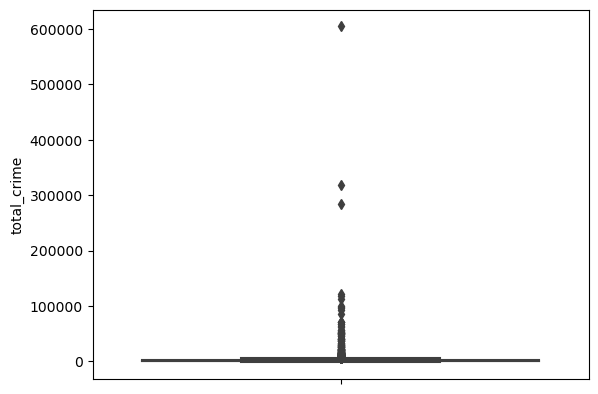

In [149]:
# Boxplot for sum of all crimes
sns.boxplot(data=df, y='total_crime')

In [150]:
# Keep on records where total_crime is greater than 0
df = df[df['total_crime'] > 0]

<AxesSubplot: >

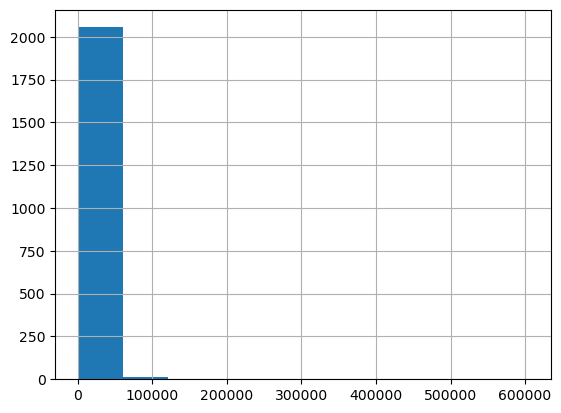

In [151]:
# Check distribution of data using histogram
df.total_crime.hist(bins=10)

In [152]:
# Check boxplot again
#sns.boxplot(data=df, y='total_crime')

In [204]:
# Define all_features using all the columns in the dataframe
all_features = df.columns.tolist()
print(all_features)

['communityName', 'state', 'population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumKidsBornNeverMar', 'PctKidsBornNeverMar', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'Pct

In [205]:
del all_features[104:]
del all_features[0:2]
print(all_features)
print("\n Number of features after removing unnecessary features: ", len(all_features))

['population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumKidsBornNeverMar', 'PctKidsBornNeverMar', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLar

In [183]:
# Drop unnecessary columns
# del all_features[104:]
# del all_features[0:2]
# del all_features[2:6]
# del all_features[17:23]
# all_features.remove("NumImmig")
# print(all_features)
# print("\n Number of features after removing unnecessary features: ", len(all_features))

['population', 'householdsize', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumKidsBornNeverMar', 'PctKidsBornNeverMar', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 

In [206]:
# Initial random forest model using all features
X = df[all_features]
y = df["total_crime"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = RandomForestRegressor(random_state=2)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=2)

In [207]:
# R^2 and mean absolute error score
y_pred = model.predict(X_test)

r_squared = metrics.r2_score(y_test, y_pred)
print('R-Squared Score:', r_squared)

mae = metrics.mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

R-Squared Score: 0.9229541487297848
Mean Absolute Error: 951.9706506024098


In [208]:
# Check feature importance
feature_imp = pd.Series(model.feature_importances_, index=all_features).sort_values(ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(feature_imp)

NumUnderPov              0.236329
numbUrban                0.189606
population               0.137983
NumKidsBornNeverMar      0.089096
HousVacant               0.087956
NumInShelters            0.079247
NumImmig                 0.069756
NumStreet                0.032305
PctUsePubTrans           0.015332
PopDens                  0.008643
agePct12t29              0.003319
PersPerFam               0.003226
PctNotHSGrad             0.002905
racePctAsian             0.002860
LemasPctOfficDrugUn      0.002606
PctWorkMom               0.002064
PctOccupManu             0.001825
agePct65up               0.001804
MalePctDivorce           0.001322
PctWorkMomYoungKids      0.001224
PctPersDenseHous         0.001224
TotalPctDiv              0.001190
MalePctNevMarr           0.001143
PctOccupMgmtProf         0.001115
PctPopUnderPov           0.001111
PctEmplProfServ          0.001088
pctWFarmSelf             0.001009
racepctblack             0.000965
PctHousLess3BR           0.000951
PctBornSameSta

In [209]:
# Define the top 5 features to use for our model again to see if scores improved
list_of_features = feature_imp.index.tolist()
top_5_features = list_of_features[:5]
top_5_features

['NumUnderPov', 'numbUrban', 'population', 'NumKidsBornNeverMar', 'HousVacant']

In [210]:
# 2nd model using top 5 features based on feature importance
X = df[top_5_features]
y = df["total_crime"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

model = RandomForestRegressor(random_state=2)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=2)

In [211]:
# R^2 and mean absolute error score
y_pred = model.predict(X_test)

r_squared = metrics.r2_score(y_test, y_pred)
print('R-Squared Score:', r_squared)

mae = metrics.mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

R-Squared Score: 0.9152081616475649
Mean Absolute Error: 936.95556626506


In [53]:
# Model hyperparameters tuning
# params = {
#     'criterion' : ['absolute_error'],
#     'n_estimators': [50, 100],
#     'max_depth': [2, 5],
#     'min_samples_split': [2, 10],
#     'min_samples_leaf': [1, 10]
#          }

# grid_search_cv =  GridSearchCV( 
#     estimator = RandomForestRegressor(), 
#     param_grid = params, 
#     scoring = 'neg_mean_absolute_error')

# grid_search_cv.fit(X_train, y_train)

# print(grid_search_cv.best_params_)

# model = grid_search_cv.best_estimator_

# print(model)

{'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
RandomForestRegressor(criterion='absolute_error', max_depth=5,
                      min_samples_split=10)
